# (Grid)Survey

Learn how to create a generic survey that observes anywhere in the sky.

`Survey` and `GridSurvey` are objects containing a footprint (imprint of the camera on the sky) and an observing strategy (where did you pointed the telescope with which filter etc.).

The main difference is that `GridSurvey` has a set of pre-defined **fields**, while `Survey` has not.

***
## Survey: *footprint* and *pointings*

Let's start with the most generic survey. It needs:
- `data`: an observing strategy (ra, dec, mjd, band, zp, skynoise etc...)
- `footprint`: the camera footprint in the sky (in degree)

### 1. Define the footprint
For this example, let's use a simple 1 degree-radius camera footprint.

The footprint in `skysurvey` is based on [shapely](https://shapely.readthedocs.io/en/stable/manual.html)

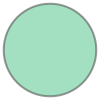

In [1]:
from shapely import geometry
footprint = geometry.Point(0,0).buffer(1)
footprint

### 2. Define the observing strategy

Say we will do 10_000 pointings: 
- `ra = [200,300]` and `dec =[-20,10]`. 
- `gain`: will be 1
- `skynoise`: between 150 ± 20
- `zp`: 30
- `mjd`: between march 2020 and april 2020
- `band`: will be desg, desr or desi

`skysurvey` data are based on `pandas.DataFrame` (you can provide dict, this will be converted though)

In [2]:
import pandas
import numpy as np
from skysurvey.tools import utils
from astropy.time import Time

In [3]:
from skysurvey.tools import utils
from astropy.time import Time
size = 10_000
data = {}

ra, dec = utils.random_radec(size=size, ra_range=[200,250], dec_range=[-20,10])
data["ra"] = ra
data["dec"] = dec
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=150, scale=20)
data["mjd"] = np.random.uniform(Time("2020-03-01").mjd, Time("2020-04-01").mjd, size=size)
data["band"] = np.random.choice(["desg","desr","desi"], size=size)

data = pandas.DataFrame.from_dict(data)
data.head()

,ra,dec,gain,zp,skynoise,mjd,band
0,203.734215,-10.845189,1,30,134.604820,58926.019592,desi
1,245.608116,7.143275,1,30,149.793298,58914.001713,desi
2,248.921343,-3.617716,1,30,126.446520,58912.497486,desr
3,215.681984,9.748426,1,30,157.865103,58914.286535,desi
4,240.525379,5.598356,1,30,157.504097,58937.500915,desg


### load a Survey  `from_pointings()`

In [6]:
import skysurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

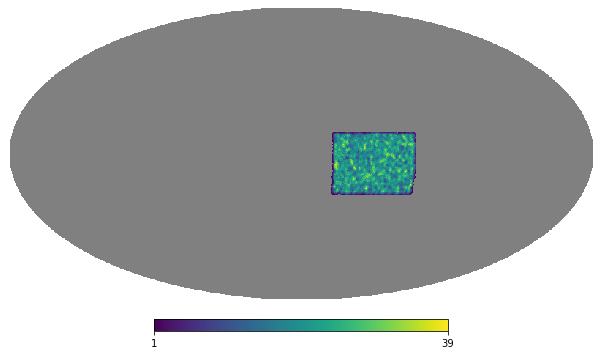

In [7]:
survey.show()

### DataFrame Based

survey.data (like any other skysurvey element) is a pandas.dataframe, so flexible and fast

In [8]:
survey.data # Show the data generated. time, band sky noise, gain, zp and fieldid.

,ra,dec,gain,zp,skynoise,mjd,band,fieldid_survey,fieldid
0,238.967056,9.991489,1,30,134.854340,58909.968750,desi,7578,194669
1,232.702621,9.993823,1,30,156.067108,58925.039062,desg,8678,194683
2,223.834122,9.989252,1,30,100.794708,58929.546875,desr,2700,194702
3,223.834122,9.989252,1,30,100.794708,58929.546875,desr,2700,194703
4,213.658463,9.985991,1,30,154.274536,58934.253906,desg,686,194725
...,...,...,...,...,...,...,...,...,...
364899,208.816757,-19.948879,1,30,136.481613,58912.476562,desi,7295,325936
364900,208.087814,-19.954334,1,30,151.730865,58930.867188,desr,2002,325937
364901,208.087814,-19.954334,1,30,151.730865,58930.867188,desr,2002,325938
364902,205.706207,-19.942360,1,30,140.218582,58918.582031,desi,2120,325943


### `Survey` is based on `healpix`

For `Survey` has no pre-defined fields, the sky is based on healpy. When you load the instance, `skysurvey` computes which healpix pixel has been observed. By default, healpix's **nside** is 200 (so a pixel is 0.08 deg^2 ; see `survey.get_field_area()`) ; **nside** is a Survey loading option.

In [9]:
# "field" surface in square degree. field here corresponds to a healpix pixel.
survey.get_field_area()

0.08594366926962348

### info: fieldids and fieldids_survey

- **fieldid**: unit of sky area, in Survey, that is healpix based, this corresponds to a healpix pixel.
- **fieldid_survey**: This is the fieldid corresponding to the initial pointing strategy you input (ra, dec).

Depending on you healpix resolution, you are likely to have many fieldid (healpix pixel) per fieldid_survey (footprint at the given RA, Dec). In that example, approximately 36. This makes sense since the camera has a "π deg^2" footprint, and the pixel area is 0.086 (pi/0.086 = 36.5)

In [10]:
survey.data.groupby("fieldid_survey")["fieldid"].nunique()

fieldid_survey
0       35
1       37
2       38
3       36
4       35
        ..
9995    37
9996    38
9997    35
9998    35
9999    38
Name: fieldid, Length: 10000, dtype: int64

In [11]:
survey.get_fieldstat("size") 

fieldid
194669    1
194683    1
194702    1
194703    1
194725    2
         ..
325936    1
325937    1
325938    1
325943    1
325944    1
Length: 18724, dtype: int64

### Matching coordinate with fields

This is an important feature that enable us to know whic field contains which target

In [12]:
survey.radec_to_fieldid([26, 70])

,fieldid
index_radec,
0,14425


In [13]:
import numpy as np
# remark that, doing that this way, it won't be homogeneous.
ra_flat = np.random.uniform(0, 190, 200)
dec_flat = np.random.uniform(-30, 90, 200)
survey.radec_to_fieldid([ra_flat,dec_flat])

,fieldid
index_radec,
0,266365
1,93470
2,46642
3,339675
4,206306
...,...
195,329987
196,282906
197,67


***

## GridSurvey: *field*, *footprint* and *pointings*

Some surveys are observing **pre-defined fields**. That is the case for ZTF, that follows grid systems, or deep-fields surveys such as DES ou LSST.

A specific version of `Survey`, `GridSurvey` has been implemented for a more realistic user experience and to avoid **`healpix` pixel approximation** ; GridSurvey is also slight faster. To associate coordinates to fields `GridSurvey` is based on `shapely` and `geopandas` only (see skysurvey.survey.PolygonSurvey for details) ; no need for healpy

### Deep-Field Survey

let's use as an example two deep field surveys:

- "cosmos": 'ra':+150.11916667, 'dec':+2.20583333,
- "xmm-lss": 'ra':+35.7083333 ,'dec':-4.749999

and let's use a 8 degree size, square camera footprint

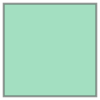

In [14]:
import numpy as np
from shapely import geometry
fields = {"cosmos": {'ra':+150.11916667, 'dec':+2.20583333},
          "xmm-lss": {'ra':+35.7083333 ,'dec':-4.749999}
         }

vertices_camera = np.asarray([[-0.5,-0.5],[0.5,-0.5], [0.5,0.5],[-0.5,0.5]]) * 8 
footprint = geometry.Polygon(vertices_camera)
footprint

### Define observation

Your observation should now not contain RA, Dec (this will be ignored), but a fieldid. 
Hence, using the very same example as above, but say we observed 10x more the cosmos field

In [15]:
import pandas
from skysurvey.tools import utils
from astropy.time import Time

size = 10_000
data = {}
# Data
data["fieldid"] = np.random.choice(["cosmos","xmm-lss"], 
                                   size=size, 
                                   p=np.asarray([10, 1])/11) # 10x 'cosmos' for 1x 'xmm-lss'
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(loc=150, scale=20,
                                    size=size)
data["mjd"] = np.random.uniform(Time("2020-03-01").mjd, Time("2020-04-01").mjd, 
                                size=size)
data["band"] = np.random.choice(["desg","desr","desi"], 
                                size=size)

data = pandas.DataFrame.from_dict(data)
data.head()

,fieldid,gain,zp,skynoise,mjd,band
0,cosmos,1,30,162.607595,58926.711832,desg
1,xmm-lss,1,30,183.266174,58939.027724,desr
2,xmm-lss,1,30,147.466105,58928.758544,desr
3,cosmos,1,30,165.267523,58926.307188,desg
4,xmm-lss,1,30,142.666700,58916.393582,desr


In [16]:
from skysurvey.survey import GridSurvey
gsurvey = GridSurvey.from_pointings(data, fields, footprint)

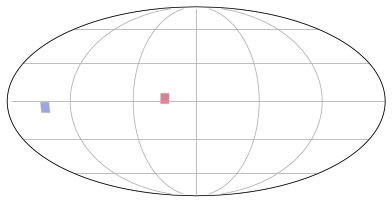

In [17]:
fig = gsurvey.show(vmin=0, vmax=10, cmap="coolwarm")

***
## Predefined Survey

- `ZTF` (GridSurvey)
- `DES` (GridSurvey) | deep-fields